In [1]:
%load_ext autoreload
%autoreload 2

# Figures for CVAE paper

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from evoscaper.utils.simulation import compute_analytics
from functools import partial
import jax

jax.config.update("jax_platform_name", 'cpu')

from evoscaper.model.evaluation import calculate_distributional_overlap
from evoscaper.utils.preprocess import make_datetime_str
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json

In [ ]:
top_write_dir = os.path.join('data', '18_figures_cvae', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

# Figure 1

In [3]:
# fn_1127 = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
# fn_0129 = 
# ds_1127 = pd.read_csv(fn_1127)
# ds_0129 = 

# Figure 2

# Figure 3

In [4]:
def calc_overlaps(analytic):
    """ Calculate for 1 sample.
    For analytic, shape is (n_conditions, n_evaluated_per_sample)
    """
    kde = calculate_distributional_overlap(analytic, dist_type='kde')
    overlaps_nodiag = kde[~np.eye(kde.shape[0], dtype=bool)
                          ].reshape(kde.shape[0], -1)
    kde_overlaps = {
        'max': overlaps_nodiag.max(axis=1),
        'min': overlaps_nodiag.min(axis=1),
        'mean': overlaps_nodiag.mean(axis=1),
        'std': overlaps_nodiag.std(axis=1)}
    return kde_overlaps


def stitch_analytics(dir_src, overwrite=False):
    dir_b = os.path.join(dir_src, 'batch_results')
    if os.path.exists(dir_b):
        analytics = {}
        for l in os.listdir(dir_b):
            fn_a = os.path.join(dir_b, l, 'analytics.json')
            if os.path.exists(fn_a):
                analytics_batch = load_json_as_dict(fn_a)
                for k, v in analytics_batch.items():
                    if k not in analytics.keys():
                        analytics[k] = []
                    analytics[k].extend(v)
        if overwrite:
            write_json(analytics, os.path.join(dir_src, 'analytics.json'))
        return analytics
    else:
        raise ValueError(
            f'No batch_results folder in {dir_src} to stitch analytics from.'
        )


idx_output = -1

## Dataset sizes

In [ ]:
dir_ds_hpo = 'data/cvae_multi/2025_03_03__21_33_13'
dir_ds_sim = 'data/cvae_multi/2025_03_09__15_19_54'
df_hpos_ds = pd.read_json(os.path.join(dir_ds_hpo, 'df_hpos.json'))
analytics_ds = load_json_as_dict(os.path.join(dir_ds_sim, 'analytics.json'))
fake_circuits_ds = np.load(os.path.join(dir_ds_sim, 'fake_circuits.npy'))
sampled_cond_ds = np.load(os.path.join(dir_ds_sim, 'sampled_cond.npy'))

if len(analytics_ds.keys()) == 0:
    ys = np.load(os.path.join(dir_ds_sim, 'ys.npy'))
    ts = np.load(os.path.join(dir_ds_sim, 'ts.npy'))
    signal_onehot = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0])
    analytics_ds = jax.vmap(partial(compute_analytics, t=ts, labels=np.arange(
        ys.shape[-1]), signal_onehot=signal_onehot))(ys)
    write_json(analytics_ds, os.path.join(dir_ds_sim, 'analytics.json'))

idx_output = -1
analytics_ds.pop('RMSE')
for k, v in analytics_ds.items():
    analytics_ds[k] = np.array(v)
    
analytics_ds['adaptation'] = calculate_adaptation(
    analytics_ds['sensitivity'], analytics_ds['precision'], alpha=2
)

In [ ]:
df_hpos_succ = df_hpos_ds[df_hpos_ds['run_successful']]

objective_col = df_hpos_ds['objective_col'].iloc[0]
objective_chosen = 'adaptation'
n_categories = df_hpos_succ['eval_n_categories'].iloc[0]
df_hpos_ds['total_ds_max'].unique(), df_hpos_ds['seed_dataset'].unique()

(array([5000000,     300,     700,    1000,    5000,   10000,   50000,
         100000,  500000, 1000000]),
 array([1, 2, 3, 4, 5]))

In [90]:
sampled_cond_ds.shape #.reshape(25, -1, 2).shape

(82, 25, 200, 2)

In [57]:
analytics_ds['adaptation'][..., idx_output].reshape(len(df_hpos_succ), np.power(n_categories, len(objective_col)), -1).shape

(82, 25, 200)

<Axes: ylabel='Density'>

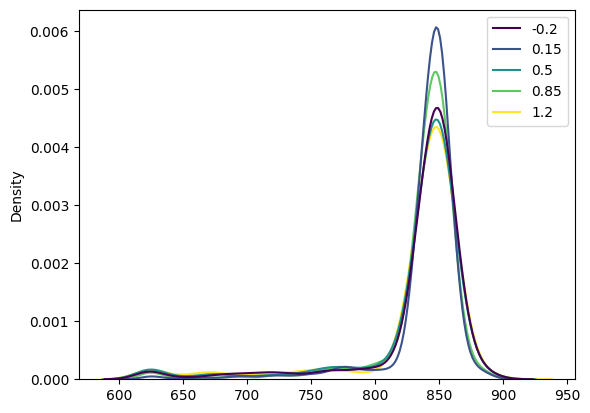

In [100]:
sns.kdeplot(x=analytics_ds['adaptation'][..., idx_output].reshape(len(df_hpos_succ), np.power(n_categories, len(objective_col)), -1)[0].flatten(),
            hue=sampled_cond_ds[0][..., 0].flatten().round(2),
            #  bins=120)
            palette='viridis')

(array([5000000,     300,     700,    1000,    5000,   10000,   50000,
         100000,  500000, 1000000]),
 array([1, 2, 3, 4, 5]))

In [ ]:
df_hpos_succ = df_hpos_ds[df_hpos_ds['run_successful']]
df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(
    lambda x: np.max([y for y in x['mean'] if y is not None])
)
eval_n_to_sample = df_hpos_succ['eval_n_to_sample'].values[0]

n_categories = 10
a = analytics_ds[objective_chosen][..., idx_output].flatten()
for k in ['mean', 'std', 'min', 'max']:
    df_hpos_succ.loc[:, f'KDE {objective_chosen} {k}'] = np.nan
kde_overlaps_all = np.zeros((len(df_hpos_succ), n_categories))
for i, (ir, r) in enumerate(df_hpos_succ.iterrows()):
    kde_overlaps = calc_overlaps(
        analytic=a[i*eval_n_to_sample:(i+1)*eval_n_to_sample].reshape(n_categories, -1),
        # analytic=a.reshape(
        #     len(df_hpos_succ), sampled_cond.shape[0] // len(df_hpos_succ), -1)[i],
        # sampled_cond=sampled_cond.reshape(
        #     len(df_hpos_succ),
        #     sampled_cond.shape[0] // len(df_hpos_succ), -1, sampled_cond.shape[-1])[i]
    )
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} min'] = kde_overlaps['min'].mean()
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} max'] = kde_overlaps['max'].mean()
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} mean'] = kde_overlaps['mean'].mean()
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} std'] = kde_overlaps['std'].mean()
    kde_overlaps_all[i] = kde_overlaps['mean']
    # print(r['temperature'], r['seed_train'], kde_overlaps['min'].mean(), kde_overlaps['max'].mean())

In [ ]:
sns.scatterplot(data=d_plot,  # [d_plot['KDE adaptation mean'] > 0.8],
                x='Temperature', y='KDE adaptation mean',
                hue='Seed',
                palette='crest',
                alpha=0.5, s=60)
sns.lineplot(x=np.repeat(df_hpos_succ['temperature'].values, repeats=n_categories),
             y=kde_overlaps_all.flatten(),
             palette='crest', alpha=0.5)
plt.legend(title='Seed')
plt.title(f'Overlap between distributions vs temperature', fontsize=18)
# plt.xlabel('Temperature', fontsize=14)
# plt.ylabel('Overlap between prompt distributions', fontsize=14)
plt.tight_layout()  # rect=[0, 0, 1, 0.95])

(np.float64(0.07844413931711611), np.float64(0.8379569402641905))

## Contrastive loss

## Stitch together re-started

In [5]:
# dir_1 = os.path.join('data', 'cvae_multi', '2025_03_27__16_33_11')
# dir_2 = os.path.join('data', 'cvae_multi', '2025_03_27__22_02_47')
# fn_hpos_1 = os.path.join(dir_1, 'df_hpos.json')
# fn_hpos_2 = os.path.join(dir_2, 'df_hpos.json')
# df_hpos_1 = pd.read_json(fn_hpos_1)
# df_hpos_2 = pd.read_json(fn_hpos_2)
# df_hpos = pd.concat([df_hpos_1.iloc[:df_hpos_2.index[0]], df_hpos_2])
# df_hpos['filename_saved_model'] = df_hpos['filename_saved_model'].str.replace(
#     dir_1, dir_2)
# df_hpos.to_json(fn_hpos_2)
# df_hpos.to_csv(
#     os.path.join(dir_2, 'df_hpos.csv')
# )

# d = os.path.join(dir_2, 'batch_results')
# for l in os.listdir(d):
#     ll = 'batch_' + str(int(l.split('_')[-1]) + 4)
#     os.rename(os.path.join(d, l), os.path.join(d, ll))

# xx_1 = np.load('data/cvae_multi/2025_03_29__15_05_30/sampled_cond.npy')
# xx_2 = np.load('data/cvae_multi/2025_03_27__22_02_47/sampled_cond_og.npy')

# xx_3 = np.concatenate(
#     [xx_1, xx_2], axis=0
# )
# print(len(xx_1), len(xx_2), len(xx_3))

# np.save('data/cvae_multi/2025_03_27__22_02_47/sampled_cond.npy', xx_3)


## Look at new contrastive loss

In [5]:
dir_contloss = 'data/cvae_multi/2025_03_27__22_02_47'
fn_df_hpos = os.path.join(dir_contloss, 'df_hpos.json')
fn_analytics = os.path.join(dir_contloss, 'analytics.json')
df_hpos = pd.read_json(fn_df_hpos)

analytics = load_json_as_dict(fn_analytics)
fake_circuits = np.load(os.path.join(dir_contloss, 'fake_circuits.npy'))
sampled_cond = np.load(os.path.join(dir_contloss, 'sampled_cond.npy'))

# Stitch batch analytics if necessary
if len(analytics['sensitivity']) != len(fake_circuits):
    analytics = stitch_analytics(dir_contloss)

objective_chosen = 'adaptation'

analytics.pop('RMSE')
for k, v in analytics.items():
    analytics[k] = np.array(v)
    
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity'], analytics['precision'], alpha=2
)

xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


In [ ]:
n_categories = 10
a = analytics[objective_chosen][..., idx_output].flatten()
kde_overlaps_all = np.ones((len(df_hpos), n_categories)) * np.nan
eval_n_to_sample = df_hpos['eval_n_to_sample'].values[0]
if f'KDE {objective_chosen} min' not in df_hpos.columns:
    df_hpos.loc[:, f'KDE {objective_chosen} min'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} max'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} mean'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} std'] = np.nan

    for i, (ir, r) in enumerate(df_hpos[df_hpos['run_successful']].iterrows()):
        if not r['run_successful']:
            continue
        kde_overlaps = calc_overlaps(
            analytic=a[i*eval_n_to_sample:(i+1) *
                       eval_n_to_sample].reshape(n_categories, -1),
        )
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} min'] = kde_overlaps['min'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} max'] = kde_overlaps['max'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} mean'] = kde_overlaps['mean'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} std'] = kde_overlaps['std'].mean()
        kde_overlaps_all[i] = kde_overlaps['mean']
        # print(r['temperature'], r['seed_train'], kde_overlaps['min'].mean(), kde_overlaps['max'].mean())

    write_json(df_hpos, fn_df_hpos)

In [7]:
df_hpos_succ = df_hpos[df_hpos['run_successful']]
df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(
    lambda x: np.max([y for y in x['mean'] if y is not None])
)


/tmp/ipykernel_543231/682999503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(


In [8]:
d_plot = pd.DataFrame()
d_plot[objective_chosen] = analytics[objective_chosen][..., idx_output].flatten()
d_plot['Prompted condition'] = sampled_cond[..., 0].flatten().round(2)
d_plot['Temperature'] = np.repeat(df_hpos_succ['temperature'], repeats=eval_n_to_sample).values.round(2)
d_plot['Seed'] = np.repeat(df_hpos_succ['seed_train'], repeats=eval_n_to_sample).values.round(2)
for k in ['Distribution overlap', f'KDE {objective_chosen} min', f'KDE {objective_chosen} max',
          f'KDE {objective_chosen} mean', f'KDE {objective_chosen} std']:
    d_plot[k] = np.repeat(df_hpos_succ[k], repeats=eval_n_to_sample).values.round(2)



Text(0.5, 0.98, 'Objective: adaptation')

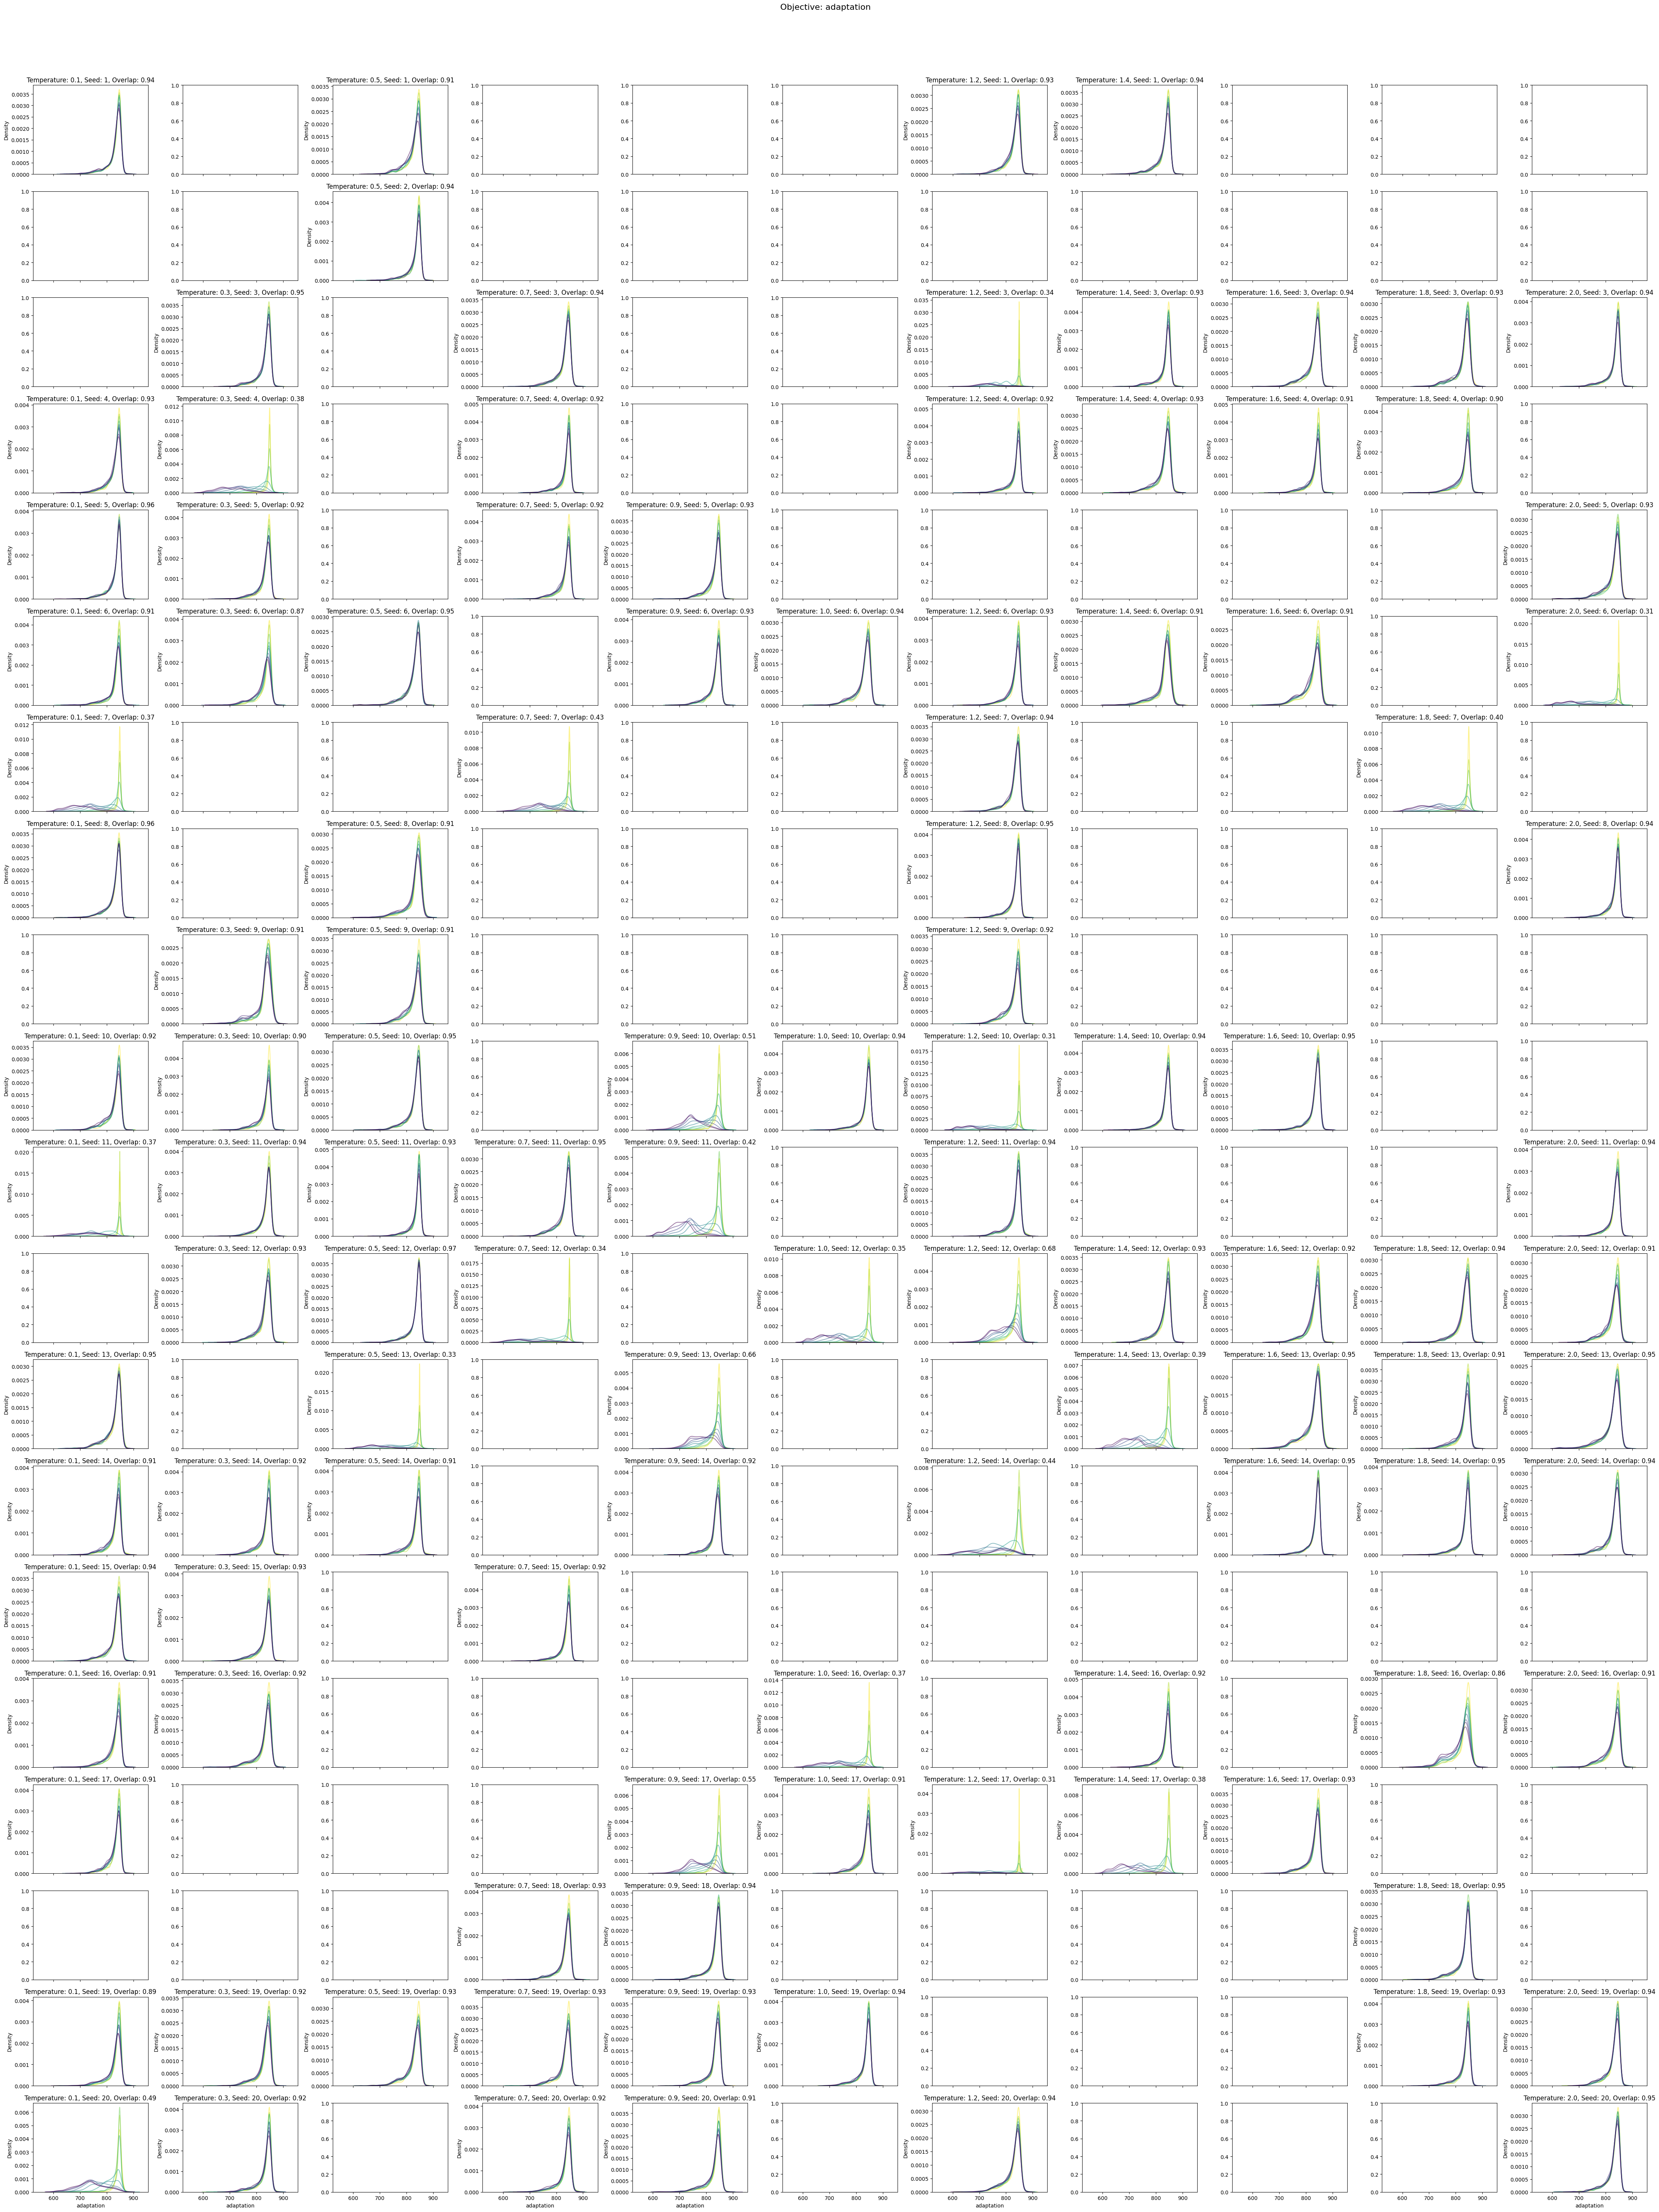

In [ ]:
# sns.kdeplot(d_plot, x=objective_chosen, hue='Prompted condition')
ncols = d_plot['Temperature'].nunique()
nrows = d_plot['Seed'].nunique()
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 1*nrows), sharey=False, sharex=True)
for i, t in enumerate(sorted(d_plot['Temperature'].unique())):
    for j, s in enumerate(sorted(d_plot['Seed'].unique())):
        filt = (d_plot['Temperature'] == t) & (d_plot['Seed'] == s)
        if d_plot[filt].shape[0] == 0:
            continue
        sns.kdeplot(d_plot[filt], x=objective_chosen, hue='Prompted condition', # bins=50, 
            palette='viridis', ax=axs[j, i], alpha=0.5, legend=False if i == 0 else False)
        axs[j, i].set_title(f'Temperature: {t:.1f}, Seed: {s}, Overlap: {d_plot[filt]["KDE adaptation mean"].values[0]:.2f}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle(f'Objective: {objective_chosen}', fontsize=16)


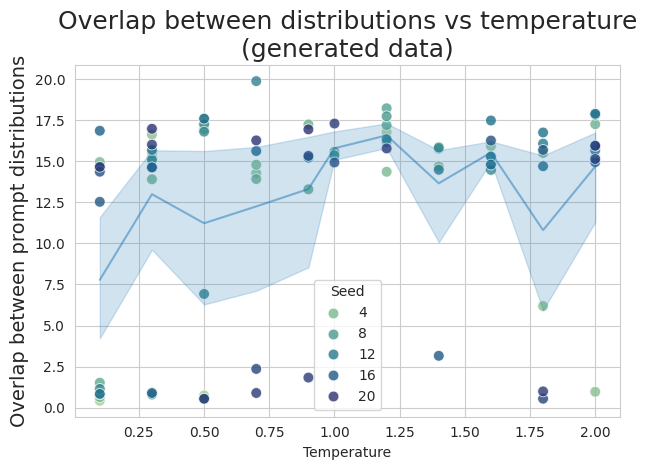

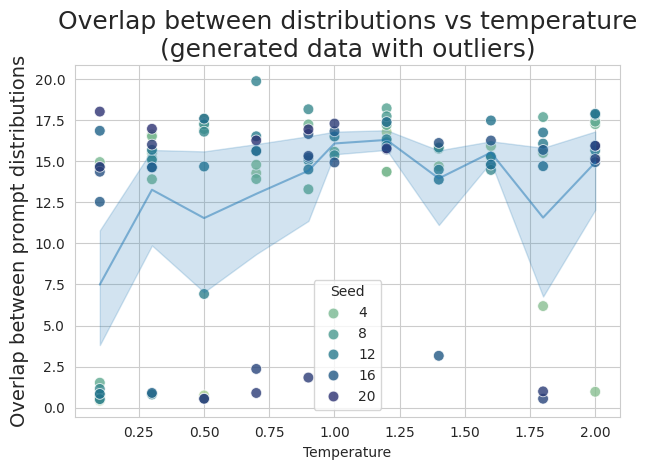

In [ ]:
if 'kl_div_ave' in df_hpos.columns:
    df_hpos['kl_div_max'] = df_hpos['kl_div_ave'].apply(lambda x: np.nanmax(list(x.values())) if type(x) != str else np.nan)
    df_hpos['kl_div_max'] = df_hpos['kl_div_max'].apply(lambda x: 1/x)
    df_hpos['kl_div_means'] = df_hpos['kl_div_ave'].apply(lambda x: np.nanmean(list(x.values())) if type(x) != str else np.nan)
    df_hpos['kl_div_means'] = df_hpos['kl_div_means'].apply(lambda x: 1/x)

df_hpos2 = df_hpos[['temperature', 'seed_train', 'KDE adaptation mean', 'kl_div_max', 'kl_div_means']].rename(columns={'temperature': 'Temperature', 'seed_train': 'Seed'})
sns.set_style('whitegrid')
sns.scatterplot(data=df_hpos2[df_hpos2['KDE adaptation mean'] > 0.8],
                x='Temperature', y='kl_div_means',
                hue='Seed', palette='crest', alpha=0.8, s=60)
sns.lineplot(data=df_hpos2[df_hpos2['KDE adaptation mean'] > 0.8],
             x='Temperature', y='kl_div_means', 
             alpha=0.5)
# sns.lineplot(x=np.repeat(df_hpos_succ['temperature'].values, repeats=n_categories),
#              y=kde_overlaps_all[df_hpos_succ.index].flatten(),
#              palette='crest', alpha=0.5)
plt.legend(title='Seed')
plt.title(f'Overlap between distributions vs temperature\n(generated data)', fontsize=18)
plt.ylabel('Overlap between prompt distributions', fontsize=14)
plt.tight_layout()  # rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'overlap_vs_temperature_fakec.png'),
            dpi=300, bbox_inches='tight', transparent=True)

plt.figure()
sns.scatterplot(data=df_hpos2, #[df_hpos2['KDE adaptation mean'] > 0.8],
                x='Temperature', y='kl_div_means',
                hue='Seed', palette='crest', alpha=0.8, s=60)
sns.lineplot(data=df_hpos2, #[df_hpos2['KDE adaptation mean'] > 0.8],
             x='Temperature', y='kl_div_means', 
             alpha=0.5)
plt.legend(title='Seed')
plt.title(f'Overlap between distributions vs temperature\n(generated data with outliers)', fontsize=18)
plt.ylabel('Overlap between prompt distributions', fontsize=14)
plt.tight_layout()  # rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'overlap_vs_temperature_fakec_woutliers.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Figure 4